In [1]:
import os.path, gym
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import roboschool
import pdb
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
GAMMA = .97
from functools import partial
try:
    env.close()
except:
    pass
if 1:
    envname = "RoboschoolInvertedPendulum-v1"
    SIZE_MULT = 2
    REWARD_MULT = 1
    N_LAYERS = 10
    N_DROP = 4
    NUM_DROP_PARALLEL = 8
    NUM_HISTORY = N_HISTORY = 2
else:
    envname = "RoboschoolHumanoidFlagrun-v1"
    SIZE_MULT = 8
    REWARD_MULT = 4
    N_LAYERS = 20
    N_DROP = 3
    NUM_DROP_PARALLEL = 6
    NUM_HISTORY = N_HISTORY = 6
DROP_RATE = .3
INIT_LEN = 200
N_PRETRAIN = 1
NUM_KEEP = 300
PERCENT_CHOOSE_OPTIMAL = 2
env = gym.make(envname)
N_OBS, N_ACT = [v.shape[0] for v in [env.observation_space, env.action_space]]
N_STATE = (N_OBS + N_ACT) * 2
REWARD_IN_STATE = 0
if REWARD_IN_STATE:
    N_STATE += 2
INPUT_UNITS = N_STATE * NUM_HISTORY
STATE_DECAY = .7
TESTING_GRAD_NORMS = 1
ADV_ENABLED = 0
STORED_MODELS = {}
FCNS = {'np':{
    'concat':np.concatenate,
    'reshape':np.reshape,
    'expand':np.expand_dims
},'tf':{
    'concat':tf.concat,
    'reshape':tf.reshape,
    'expand':tf.expand_dims
}}

/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


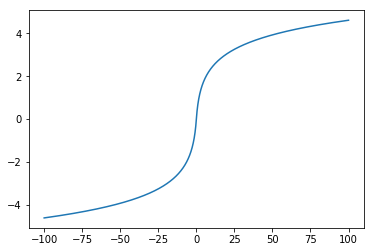

In [2]:
x = np.arange(-100, 100, .01)

y = np.log(np.abs(x)+1) * np.sign(x)

plt.plot(x, y)

In [3]:

def apply_clipped_optimizer(opt_fcn,
                            loss,
                            clip_norm=.1,
                            clip_single=.03,
                            clip_global_norm=False,
                            var_list=None):
    if var_list is None:
        gvs = opt_fcn.compute_gradients(loss)
    else:
        gvs = opt_fcn.compute_gradients(loss, var_list = var_list)
        

    if clip_global_norm:
        gs, vs = zip(*[(g, v) for g, v in gvs if g is not None])
        capped_gs, grad_norm_total = tf.clip_by_global_norm([g for g in gs],clip_norm)
        capped_gvs = list(zip(capped_gs, vs))
    else:
        grad_norm_total = tf.sqrt(
                tf.reduce_sum([
                        tf.reduce_sum(tf.square(grad)) for grad, var in gvs
                        if grad is not None
                ]))
        capped_gvs = [(tf.clip_by_value(grad, -1 * clip_single, clip_single), var)
                                    for grad, var in gvs if grad is not None]
        capped_gvs = [(tf.clip_by_norm(grad, clip_norm), var)
                                    for grad, var in capped_gvs if grad is not None]

    optimizer = opt_fcn.apply_gradients(capped_gvs)

    return optimizer, grad_norm_total

class MLP:
    def __init__(self,
                x, lshapes, output_units, namebase, squeeze = True,
                lshapes_drop = None, drop_rate = DROP_RATE, reuse = False,
                residual = None
                ):
        self.namebase = namebase
        self.reuse = reuse
        self.lidx = 0
        name_fcn = self.get_name
        h = [tf.nn.leaky_relu(tf.layers.dense(
            x, lshapes[0], name=self.get_name(), reuse = self.reuse))]
        h2 = h[-1]
        for size in lshapes:
            h.append(tf.nn.leaky_relu(h[-1] + tf.layers.dense(
                h2, size, name=name_fcn(), reuse = self.reuse)))
            h2 = h[-1]#tf.concat((x, h[-1]), -1)
        if lshapes_drop is None:
            hout = h[-1]
            output = tf.layers.dense(
                hout, output_units, name=name_fcn(), reuse = self.reuse)
            if output_units == 1 and squeeze:
                output = tf.squeeze(output, -1)
            self.raw_output = output
            self.output = leaky_tanh(self.raw_output)
            if residual is not None:
                self.output = self.output + residual
        else:
            drop_outs = []
            x_drop = h[-1]
            name_fcn = self.get_name_drop
            self.lidx_drop = 0
            for drop_idx, drop_try in enumerate(range(NUM_DROP_PARALLEL)):
                h_drop = [x_drop]
                for lsize in lshapes_drop:
                    new_layer = tf.nn.dropout(tf.nn.leaky_relu(tf.layers.dense(
                        h_drop[-1], size, name=name_fcn(), reuse = self.reuse)), keep_prob = 1-drop_rate)
                    h_drop.append(new_layer)
                    new_layer = tf.nn.leaky_relu(tf.layers.dense(
                        h_drop[-1], size, name=name_fcn(), reuse = self.reuse))
                    h_drop.append(new_layer)
                output = tf.layers.dense(h_drop[-1], output_units)
                if output_units == 1 and squeeze:
                    output = tf.squeeze(output, -1)
                output = output
                if residual is not None:
                    output = output + residual
                drop_outs.append(output)
                self.reuse = True
                self.lidx_drop = 0
            self.output = tf.stack(drop_outs, -1)
            self.output_mean, self.variance = tf.nn.moments(self.output, -1)
    def get_name(self):
        self.lidx = self.lidx + 1
        return self.namebase + str(self.lidx)
    def get_name_drop(self):
        self.lidx_drop = self.lidx_drop + 1
        return self.namebase + '_drop_' + str(self.lidx_drop)

In [4]:


def make_state(state, action, style = 'np'):
    together = FCNS[style]['concat']((state, action), -1)
    if style == 'tf':
        return together
#         expanded = FCNS[style]['expand'](
#             together, 1)
    else:
        expanded = FCNS[style]['expand'](
            together, 0)
    return expanded
    return FCNS[style]['reshape'](
        together, (state.shape[0], -1, state.shape[-1] + action.shape[-1]))
        
    

def accumulate_state(state, action, old_state, statedecay, style = 'np'):
    new_state = make_state(state, action, style)
    new_state_len = new_state.shape[-1]
    if style == 'tf':
        vel = new_state - old_state[:,:,0,:new_state_len]
    else:
        vel = new_state - old_state[0,:new_state_len]
    new_state = FCNS[style]['concat']((new_state, vel), -1)
    if style == 'tf':
        return FCNS[style]['concat']((tf.expand_dims(new_state, 2), old_state[:,:,:-1,:]*statedecay), 2)
    return FCNS[style]['concat']((new_state, old_state[:-1,:]*statedecay), 0)

def leaky_tanh(x):
    return tf.log(tf.abs(x)+1) * tf.sign(x)*.7
    #return tf.nn.tanh(x*30)/10 + tf.nn.tanh(x*2)/2 + tf.nn.tanh(x/20) * 2 + x * 1e-3

In [5]:

def get_grad_norm(optimizer, loss, optname):
    gvs = optimizer.compute_gradients(loss)
    grad_norm = tf.reduce_mean(
        [tf.reduce_mean(tf.square(grad)) for
         grad, var in gvs if grad is not None and optname in var.name])
    return grad_norm

In [6]:


class PolicyLearner(object):
    def __init__(self, ob_space, ac_space, take_weights_here=None, 
                 lshapes = [32 * SIZE_MULT] * N_LAYERS, config = None, 
                 lshapes_small = [16 * SIZE_MULT] * (N_LAYERS//2),
                 lshapes_smaller = [16 * SIZE_MULT] * (N_LAYERS//2),
                 lshapes_drop = [16 * SIZE_MULT] * N_DROP,
                reuse = False):
        self.sess = tf.InteractiveSession(config=config)
        self.obs_raw = tf.placeholder(tf.float32, (None, None, NUM_HISTORY, N_STATE))
        self.returns = tf.placeholder(tf.float32, (None, None))
        self.returnsdecayed = tf.placeholder(tf.float32, (None, None))
        self.mask = tf.placeholder(tf.float32, (None, None))
        self.lr = tf.placeholder_with_default(1e-3, (None))
        self.statesraw = tf.placeholder(tf.float32, (None, None, N_OBS))
        self.is_train = tf.placeholder_with_default(True, (None))
        self.is_exploit = tf.placeholder(tf.float32, (None))
        self.is_exploit2d = tf.expand_dims(self.is_exploit, -1)
        self.is_exploit3d = tf.expand_dims(self.is_exploit2d, -1)
        self.statesraw_expanded = tf.expand_dims(self.statesraw, -1)
        self.obs_raw_expanded = tf.expand_dims(self.obs_raw, -1)
        self.maskexpanded = tf.expand_dims(self.mask, -1)
        self.maskexpanded2 = tf.expand_dims(self.maskexpanded, -1)
        self.obs = tf.reshape(
            self.obs_raw, (
                tf.shape(self.obs_raw)[0], tf.shape(self.obs_raw)[1], N_STATE * NUM_HISTORY))
        self.actor = MLP(
            self.obs, lshapes, N_ACT, 'a_', squeeze = False, reuse = reuse)
        self.explorer = MLP(
            self.obs, lshapes, N_ACT, 'e_', squeeze = False, reuse = reuse, residual = self.actor.output)
        self.actions = self.actor.output
        self.explorer_actions = self.explorer.output
        self.state_value_estimator = MLP(
            self.obs, lshapes_smaller, 1, 'v_', reuse = reuse)
        self.state_value_estimate = self.state_value_estimator.output
        
        self.advantage = ((
            self.state_value_estimate[:,1:] * GAMMA + self.returns[:,:-1]) -
            self.state_value_estimate[:,:-1])
        
        self.critic_input = tf.concat((self.obs, self.actions), -1)
        self.explorer_critic_input = tf.concat((self.obs, self.explorer.output), -1)
        
        self.advantage_estimator = MLP(
            self.critic_input, lshapes_small, 1, 'c_', lshapes_drop = lshapes_drop, reuse = reuse)
        self.model_estimator = MLP(
            self.critic_input, lshapes_small, N_OBS, 'm_', lshapes_drop = lshapes_drop, reuse = reuse,
            residual = self.statesraw
        )
        self.explorer_advantage_estimator = MLP(
            self.explorer_critic_input, lshapes_small, 1, 'c_', lshapes_drop = lshapes_drop, reuse = True)
        self.explorer_model_estimator = MLP(
            self.explorer_critic_input, lshapes_small, N_OBS, 'm_', lshapes_drop = lshapes_drop, reuse = True,
            residual = self.statesraw
        )
        self.advantage_estimate = self.advantage_estimator.output_mean
        self.model_estimate = self.model_estimator.output_mean
        self.future_obs_raw = accumulate_state(
            self.model_estimate, self.actions, self.obs_raw, STATE_DECAY, style = 'tf')
        self.explorer_future_obs_raw = accumulate_state(
            self.explorer_model_estimator.output_mean, self.explorer_actions,
            self.obs_raw, STATE_DECAY, style = 'tf')
        
        self.future_obs = tf.reshape(self.future_obs_raw, 
            (tf.shape(self.future_obs_raw)[0],tf.shape(self.future_obs_raw)[1], N_STATE * NUM_HISTORY))
        self.explorer_future_obs = tf.reshape(self.explorer_future_obs_raw, 
            (tf.shape(self.explorer_future_obs_raw)[0],
             tf.shape(self.explorer_future_obs_raw)[1], N_STATE * NUM_HISTORY))
        
        self.future_value = MLP(
            self.future_obs, lshapes_smaller, 1, 'v_', reuse = True)
        
        self.future_actor = MLP(
            self.future_obs, lshapes, N_ACT, 'a_', reuse = True, squeeze = False)
        self.future_actions = self.future_actor.output
        
        self.future_critic_input = tf.concat((self.future_obs, self.future_actions), -1)
        self.future_advantage_estimator = MLP(
            self.future_critic_input, lshapes_small, 1, 'c_', lshapes_drop = lshapes_drop, reuse = True)
        
        if len(self.future_actions.shape) == 2:
            self.future_actions = tf.expand_dims(self.future_actions, -1)
        
        self.t_vars = tf.trainable_variables()
        self.a_vars = [var for var in self.t_vars if 'a_' in var.name]
        self.v_vars = [var for var in self.t_vars if 'v_' in var.name]
        self.c_vars = [var for var in self.t_vars if 'c_' in var.name]
        self.e_vars = [var for var in self.t_vars if 'e_' in var.name]
        self.m_vars = [var for var in self.t_vars if 'm_' in var.name]
        
        self.creg, self.areg, self.vreg, self.mreg, self.ereg = [
            tf.reduce_mean([tf.reduce_mean(tf.square(v)) for v in optvars]) * 1e0
            for optvars in 
            [self.c_vars, self.a_vars, self.v_vars, self.m_vars, self.e_vars]]
        
        def mplusv(x):
            return x.variance + x.output_mean
        
        self.explorer_adv_loss = -tf.reduce_mean(mplusv(
            self.explorer_advantage_estimator) * self.mask)
        self.explorer_mdl_loss = -tf.reduce_mean(
            self.explorer_model_estimator.variance * self.maskexpanded)
        self.e_mse = tf.reduce_mean(
            tf.square(self.explorer.raw_output) * self.maskexpanded) * 1e-1
        
        
        
        self.model_state_estimate = self.model_estimator.output_mean
        
        self.v_loss_raw = tf.reduce_mean(tf.square(
            self.returnsdecayed - self.state_value_estimate) * self.mask * self.is_exploit2d) * 3
        
        self.m_loss_raw = tf.reduce_mean(tf.square(
            self.model_estimator.output[:,:-1] - self.statesraw_expanded[:,1:]
        ) * self.maskexpanded2[:,:-1]) * 10000
        
        self.c_loss_raw = tf.reduce_mean(tf.square(
            self.advantage_estimate[:,:-1] - self.advantage) * self.mask[:,:-1]) * 3
        
        
        self.actionmean = tf.reduce_sum(
            self.actions * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1) + tf.reduce_sum(
            self.future_actions * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1) 
        
        
        self.actionmean = tf.reduce_sum(
            self.actions * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1)
        self.actdiffsquared = tf.square(
            self.actions - tf.expand_dims(self.actionmean, 1))
        self.actvar = tf.reduce_sum(
            self.actdiffsquared * self.maskexpanded, 1)/ tf.reduce_sum(
            self.maskexpanded, 1)
        self.actstd = self.actvar
        self.actstdpenalty = -tf.reduce_mean(
            tf.log(self.actstd + .00001)* .00001 + tf.square(self.actstd)) * .001
        
        self.aregmeanbyaction = tf.reduce_mean(
            tf.square(self.actionmean)) * 1e3
        self.a_mse = tf.reduce_mean(
            tf.square(self.actor.raw_output) * 1e2 + 
            tf.square(self.future_actor.raw_output) * 1e-1 +
            tf.square(tf.square(self.actor.raw_output)) * 1e1 + 
            tf.square(tf.square(self.future_actor.raw_output)) * 1e-3
            )
            
        self.frac_not_masked = tf.reduce_mean(self.mask)
        
        self.a_loss_critic = -tf.reduce_mean(
            self.advantage_estimator.output_mean * self.mask)/self.frac_not_masked * 2000
        self.a_loss_model = -tf.reduce_mean(
            self.future_value.output * self.mask)/self.frac_not_masked * 1.
        self.a_loss_secondaction = -tf.reduce_mean(
            self.future_advantage_estimator.output_mean * self.mask)/self.frac_not_masked * .1
        
        self.grad_v = tf.square(tf.gradients(
            self.state_value_estimator.output * self.mask, self.obs)[0])
        self.grad_m = tf.square(tf.gradients(
            self.model_estimator.output * self.maskexpanded2, self.critic_input)[0])
        self.grad_c = tf.square(tf.gradients(
            self.advantage_estimator.output * self.maskexpanded, self.critic_input)[0])
        
        self.grad_norm_m = tf.reduce_mean(self.grad_m) * 1e-2
        self.grad_norm_v = tf.reduce_mean(self.grad_v) * 1e-4
        self.grad_norm_c = tf.reduce_mean(self.grad_c) * 1e-2
    
        slopes = tf.reduce_sum(tf.square(self.grad_c), reduction_indices=[2])
        self.grad_c_1 = tf.reduce_mean(self.mask * (slopes - .2) ** 2) * 1e-3
        slopes = tf.reduce_sum(tf.square(self.grad_m), reduction_indices=[2])
        self.grad_m_1 = tf.reduce_mean(self.mask * (slopes - .2) ** 2) * 1e-5
        
        
        self.critic_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.value_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.actor_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.model_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.explorer_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        
        
        self.actor_current_mult = []
        self.critic_current_mult = []
        self.actor_loss_mults = []
        self.critic_loss_mults = []
        self.critic_loss_grads = []
        self.actor_loss_grads = []
        self.actor_loss_targets = np.array([30., 1., .1,1e-6, .1, .01, .01,
                                           10., 1., 1e-6, .01])
        self.actor_loss_names = ['a_loss_critic', 'a_loss_model', 'a_loss_secondaction', 
                    'areg', 'aregmeanbyaction', 'actstdpenalty', 'a_mse',
                    'explorer_adv_loss', 'explorer_mdl_loss', 'ereg',
                     'e_mse'
                                ]
        self.critic_loss_targets = np.array(
            [10, 10, 10,
             .001, .001, .001, 
            .001, .001,
            1e-8, 1e-8, 1e-8])
        self.critic_loss_names = [
            'v_loss_raw','m_loss_raw', 'c_loss_raw',
            'grad_norm_c',  'grad_norm_v', 'grad_norm_m', 
            'grad_m_1', 'grad_c_1',
             'creg','vreg', 'mreg']
        self.aopts = [self.actor_opt] * 7 + [self.explorer_opt] * 4
        self.aoptnames = ['a_'] * 7 + ['e_'] * 4
        self.copts = [self.value_opt, self.model_opt, self.critic_opt, 
                      self.critic_opt, self.value_opt,
                      self.model_opt, self.model_opt, self.critic_opt, 
                      self.critic_opt, self.value_opt,self.model_opt]
        self.coptnames = [v + '_' for v in ['v', 'm', 'c', 'c', 'v', 'm', 'm', 'c', 'c', 'v', 'm']]
        for lidx, loss in enumerate(self.actor_loss_names):
            opt = self.aopts[lidx]
            optname = self.aoptnames[lidx]
            loss_mult = tf.placeholder_with_default(1., (None))
            self.actor_loss_mults.append(loss_mult)
            setattr(self, loss, getattr(self, loss) * loss_mult)
            self.actor_loss_grads.append(get_grad_norm(opt, getattr(self, loss), optname))
            self.actor_current_mult.append(1)
            if loss == 'a_mse':
                self.amse_mult = loss_mult
            if loss == 'e_mse':
                self.emse_mult = loss_mult
        for lidx, loss in enumerate(self.critic_loss_names):
            opt = self.copts[lidx]
            optname = self.coptnames[lidx]
            loss_mult = tf.placeholder_with_default(1., (None))
            self.critic_loss_mults.append(loss_mult)
            setattr(self, loss, getattr(self, loss) * loss_mult)
            self.critic_loss_grads.append(get_grad_norm(opt, getattr(self, loss), optname))
            self.critic_current_mult.append(1)
        self.actor_current_mult = np.array(self.actor_current_mult)
        self.critic_current_mult = np.array(self.critic_current_mult)
        
        self.v_loss =  self.v_loss_raw + self.vreg
        self.m_loss = self.m_loss_raw + self.mreg
        self.c_loss =  self.c_loss_raw + self.creg
        self.aregtotal = self.areg + self.aregmeanbyaction + self.actstdpenalty + self.a_mse
        self.a_loss_raw = self.a_loss_critic + self.a_loss_model + \
            self.a_loss_secondaction
        self.a_loss = self.a_loss_raw + self.aregtotal
        
        
        self.e_loss_minimize = self.explorer_adv_loss + self.explorer_mdl_loss + self.e_mse + self.ereg
        self.a_loss_minimize = self.a_loss
        self.c_loss_minimize = self.c_loss + self.grad_norm_c + self.grad_c_1
        self.v_loss_minimize = self.v_loss + self.grad_norm_v
        self.m_loss_minimize = self.m_loss + self.grad_norm_m + self.grad_m_1
        
        
#         if TESTING_GRAD_NORMS:
#             self.a_grads = [
#                 get_grad_norm(self.actor_opt, l) for l in [
#                 self.a_loss_minimize, self.a_loss_raw, self.a_loss_critic,self.a_loss_model,
#                 self.a_loss_secondaction,
#                 self.areg, self.aregmeanbyaction, self.actstdpenalty, self.a_mse
#             ]]
#             self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
#                 self.v_loss_minimize, self.v_loss_raw, 
#                 self.vreg, self.grad_norm_v
#             ]]
#             self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
#                 self.c_loss_minimize, self.c_loss_raw, 
#                 self.creg, self.grad_norm_c, self.grad_c_1

#             ]]
#             self.m_grads = [get_grad_norm(self.critic_opt, l) for l in [
#                 self.m_loss_minimize, self.m_loss_raw, 
#                 self.mreg, self.grad_norm_m, self.grad_m_1
#             ]]
        
        self.copt, self.c_norm = apply_clipped_optimizer(
            self.critic_opt, self.c_loss_minimize, var_list = self.c_vars)
        self.vopt, self.v_norm = apply_clipped_optimizer(
            self.value_opt, self.v_loss_minimize, var_list = self.v_vars)
        self.aopt, self.a_norm = apply_clipped_optimizer(
            self.actor_opt, self.a_loss_minimize, var_list = self.a_vars)
        self.mopt, self.m_norm = apply_clipped_optimizer(
            self.model_opt, self.m_loss_minimize, var_list = self.m_vars)
        self.eopt, self.e_norm = apply_clipped_optimizer(
            self.explorer_opt, self.e_loss_minimize, var_list = self.e_vars)

    def a_name(self):
        self.a_idx += 1
        return 'a_' + str(self.a_idx)
    def c_name(self):
        self.c_idx += 1
        return 'c_' + str(self.c_idx)
    def v_name(self):
        self.v_idx += 1
        return 'v_' + str(self.v_idx)
    def m_name(self):
        self.m_idx += 1
        return 'm_' + str(self.m_idx)
    def e_name(self):
        self.e_idx += 1
        return 'e_' + str(self.e_idx)
    
    def load_weights(self):
        feed_dict = {}
        for (var, w), ph in zip(
            self.assigns, self.weight_assignment_placeholders):
            feed_dict[ph] = w
        self.sess.run(self.weight_assignment_nodes, feed_dict=feed_dict)

    def act(self, obs, exploit = True):
        # Because we need batch dimension, 
        # data[None] changes shape from [A] to [1,A]
        if exploit:
            act = self.actions
        else:
            act = self.explorer_actions
        a = self.sess.run(
            act, feed_dict={
                self.obs_raw:np.reshape(obs, (1, 1, N_HISTORY, N_STATE)),
                self.is_train:False
            })
        return a[0][0]  # return first in batch



config = tf.ConfigProto(
    inter_op_parallelism_threads=0,
    intra_op_parallelism_threads=0,
    device_count = { "GPU": 0 } )
tf.reset_default_graph()

pi = PolicyLearner(env.observation_space, env.action_space, config = config)

sess = pi.sess
self = pi
sess.run(tf.global_variables_initializer())
#trainer = ZooPolicyTensorflow(
# "mymodel1", env.observation_space, env.action_space)
saver = tf.train.Saver()

In [7]:
# env.close()


# env = gym.make(envname)

In [8]:
self.actor_current_mult = np.ones_like(self.actor_current_mult,dtype=np.float32)
self.critic_current_mult = np.ones_like(self.critic_current_mult,dtype=np.float32)

In [9]:

#         self.advantage = ((
#             self.stateraw_value_estimate[:,1:] * GAMMA + self.returns) -
#             self.state_value_estimate[:,:-1])

In [10]:

ah, sh, shraw, rh, rdecayedh, maskh = [
    np.zeros((0, 0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
isexploit = []
globalframes = []
localframes = []
ep = 0
trained = 0
ongoing = 0
printfreq = 20
obj_fname = envname + str(PERCENT_CHOOSE_OPTIMAL) + 'saveobjs_unguided.pkl'
tffile = "tmp/" + envname + str(PERCENT_CHOOSE_OPTIMAL) + "unguided_trained.ckpt"
import pickle

In [11]:
ongoing = 0
sess.run(tf.global_variables_initializer())

In [12]:
if ongoing:
    
    save_path = saver.save(sess, tffile)
    print('saved at epoch', ep)
    with open(obj_fname,"wb") as f:
        pickle.dump(
            [ah, sh, rh, rdecayedh, maskh, ep, globalframes, isexploit
            ], f)
    trained = 1

In [13]:

def train_actor(self, feed_dict, printon):
    _, _, aloss = sess.run(
        [self.aopt, self.eopt, self.a_loss],
        feed_dict = feed_dict
            )
    if TESTING_GRAD_NORMS and ep % printfreq == 0 and printon and ep > INIT_LEN:
        cur_grad_norms = sess.run(self.actor_loss_grads, feed_dict)
        target = self.actor_loss_targets
        problem_factor = cur_grad_norms / target
        for fidx, factor in enumerate(problem_factor):
            if fidx == len(problem_factor) - 1:
                pass#pdb.set_trace()
            if factor > 100:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] / 10
            elif factor > 10:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] / 2
            elif factor < .01:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] * 10
            elif factor < .1:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] * 2
            self.actor_current_mult[fidx] = np.clip(self.actor_current_mult[fidx], 1e-5, 1e5)
        print(list(zip(self.actor_loss_names, cur_grad_norms, target, self.actor_current_mult)))
    return aloss

In [14]:
def train(actor = True, value = True, n_steps = 1, forced_hist = 2):
    for itr in range(n_steps):
        if num_hist >  batch_size:
            #probability = np.arange(num_hist - forced_hist)
            probability = num_steps_per_run = (
                maskh.shape[1] - maskh[:,::-1].argmax(1))
            if forced_hist:
                probability = probability[:-forced_hist]
            probability = np.square(probability)
            probability = probability / probability.sum()
            rnd = np.random.choice(
                    num_hist - forced_hist, batch_size - forced_hist, 
                    replace=False, p=probability)
            if forced_hist:
                samples = np.concatenate((rnd,
                    np.arange( num_hist - forced_hist, num_hist)))
            else:
                samples=rnd
        else:
            samples = np.random.choice(num_hist, num_hist, replace=False)
        #samples = np.array([-2, -1])
        actions, states, statesraw, returns, returnsdecayed, mask, exploit = [
            v[samples] for v in [ah, sh, shraw, rh,rdecayedh, maskh, np.array(isexploit)]]
        
        feed_dict={
                    self.returns:returns,
                    self.statesraw: statesraw,
                    self.returnsdecayed:returnsdecayed,
                    self.lr: .02 / np.power(ep + 20, .4),
                    self.mask:mask,
                    self.obs_raw: states.reshape(*states.shape[:2], N_HISTORY, N_STATE),
                    self.is_exploit:exploit,
                    self.actions:actions
        }
        for lph, lmult in zip(self.actor_loss_mults, self.actor_current_mult):
            feed_dict[lph] = lmult
        for lph, lmult in zip(self.critic_loss_mults, self.critic_current_mult):
            feed_dict[lph] = lmult
        self.amse_mult = 1.
        self.emse_mult = 1.
        if value:
            if exploit.sum() > 1:
                _,_, _, mloss, closs, vloss = sess.run(
                    [self.mopt, self.copt,self.vopt, self.m_loss, self.c_loss, self.v_loss],
                        feed_dict=feed_dict)
            else:
                _, mloss = sess.run(
                    [self.mopt, self.m_loss],
                        feed_dict=feed_dict)
                closs = vloss = 0
        else:
            mloss = closs =  vloss = 0
        del feed_dict[self.actions]
        if actor and exploit.sum() > 1:
            aloss = train_actor(self, feed_dict, printon = itr == 0)
        else:
            aloss = 0
    if 1:
        if ep % printfreq == 0 and exploit.sum() > 1:
            print('aloss', aloss, 'closs', closs, 'vloss', vloss, 'mloss', mloss)
            if TESTING_GRAD_NORMS and ep > INIT_LEN:
                
                cur_grad_norms = sess.run(self.critic_loss_grads, feed_dict)
                target = self.critic_loss_targets
                problem_factor = cur_grad_norms / target
                for fidx, factor in enumerate(problem_factor):
                    if factor > 100:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] / 10
                    elif factor > 10:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] / 2
                    elif factor < .01:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] * 10
                    elif factor < .1:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] * 2
                print(list(zip(
                    self.critic_loss_names, cur_grad_norms, target, self.critic_current_mult)))
    if ep % printfreq == 0:
        print(' ep, ', ep, ' avg frames',np.mean(globalframes[-20:]))
        print('abs action',np.abs(ah)[-1,0,:].shape, np.abs(ah)[-1,0,:].mean())
        print('max reward',np.max(rh[-10:,10:]))
    if ep % 10000 == 0:
        clear_output()
    if ep % 100 == 0:
        ysmoothed = gaussian_filter1d(globalframes, sigma=4)
        plt.plot(ysmoothed)
        plt.show()
    return feed_dict

In [15]:
trained = 0

In [16]:
# for _ in range(1):
#     feed_dict = train(actor = True, value = True, n_steps = 100)

In [17]:
exploit = 0

In [18]:
trained

0

score 44.0  frames 22
saved at epoch 100
saved at epoch 200
aloss -1056.8217 closs 13.939738 vloss 9.380328 mloss 70.26559
[('v_loss_raw', 0.0017752616, 10.0, 10.0), ('m_loss_raw', 7.412723, 10.0, 1.0), ('c_loss_raw', 0.0013809875, 10.0, 10.0), ('grad_norm_c', 3.2501362e-09, 0.001, 10.0), ('grad_norm_v', 3.5187773e-13, 0.001, 10.0), ('grad_norm_m', 1.4013674e-09, 0.001, 10.0), ('grad_m_1', 0.036250807, 0.001, 0.5), ('grad_c_1', 0.000112994945, 0.001, 1.0), ('creg', 1.5132101e-09, 1e-08, 1.0), ('vreg', 1.1386301e-07, 1e-08, 0.5), ('mreg', 2.1077213e-09, 1e-08, 1.0)]
 ep,  220  avg frames 16.360148514851485
abs action (1,) 0.35146987438201904
max reward 2.0
aloss -2482.2063 closs 126.49638 vloss 2407.6174 mloss 77.38941
[('v_loss_raw', 7.5709662, 10.0, 10.0), ('m_loss_raw', 6.764461, 10.0, 1.0), ('c_loss_raw', 0.034719177, 10.0, 100.0), ('grad_norm_c', 3.2931218e-06, 0.001, 100.0), ('grad_norm_v', 0.35295826, 0.001, 1.0), ('grad_norm_m', 1.7659373e-07, 0.001, 100.0), ('grad_m_1', 0.00371

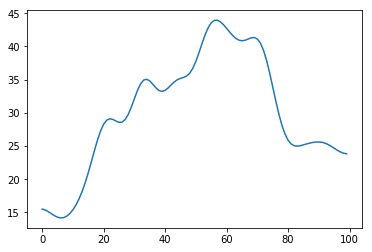

[('a_loss_critic', 368.98044, 30.0, 0.25), ('a_loss_model', 9.634305, 1.0, 40.0), ('a_loss_secondaction', 0.004400201, 0.1, 2000.0), ('areg', 5.0397693e-07, 1e-06, 1.0), ('aregmeanbyaction', 1.543263, 0.1, 0.005), ('actstdpenalty', 0.0023566391, 0.01, 200.0), ('a_mse', 436.3297, 0.01, 9.999999e-05), ('explorer_adv_loss', 39556.03, 10.0, 0.0025), ('explorer_mdl_loss', 11850.719, 1.0, 0.02), ('ereg', 7.74093e-06, 1e-06, 0.5), ('e_mse', 7363.1616, 0.01, 9.999999e-05)]
aloss -1350.4484 closs 1400.5237 vloss 6464.8813 mloss 107.139305
[('v_loss_raw', 2.6021385, 10.0, 20.0), ('m_loss_raw', 4.487883, 10.0, 2.0), ('c_loss_raw', 578.3931, 10.0, 25.0), ('grad_norm_c', 0.018005222, 0.001, 25.0), ('grad_norm_v', 1.857762e-09, 0.001, 50.0), ('grad_norm_m', 0.00013630472, 0.001, 800.0), ('grad_m_1', 0.000100057405, 0.001, 0.25), ('grad_c_1', 76.08788, 0.001, 9.999999e-06), ('creg', 4.3260645e-08, 1e-08, 1.0), ('vreg', 3.3585525e-08, 1e-08, 0.05), ('mreg', 3.4208945e-08, 1e-08, 1.0)]
 ep,  320  avg f

KeyboardInterrupt: 

In [19]:
if trained:
    try:
        saver.restore(sess, tffile)
        with open(obj_fname, "rb") as f:
            ah, sh, shraw, rh, rdecayedh, maskh, ep, globalframes, isexploit = pickle.load(f)
        print('restored from save file')
    except:
        print('no save file detected')
        trained = 0
MAX_SEQ_LEN = 5000
for ep in range(ep, 10000000):
    if ep % 100 == 0 and trained and ep > 0:
        save_path = saver.save(sess, tffile)
        print('saved at epoch', ep)
        with open(obj_fname,"wb") as f:
            pickle.dump(
                [ah[-NUM_KEEP:], sh[-NUM_KEEP:], shraw[-NUM_KEEP:],
                 rh[-NUM_KEEP:], rdecayedh[-NUM_KEEP:], maskh[-NUM_KEEP:], ep, globalframes, isexploit[-NUM_KEEP:]
                ], f)
    trained = 1
    ongoing = 1
    
    an, sn, snraw, rn, rdecayedn, maskn = [
        np.zeros((0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
    frame = 0
    score = 0
    restart_delay = 5
    obs = env.reset()
    obsraw = obs
    snraw = np.concatenate((snraw, obs.reshape(1, -1)), 0)
    obs = np.concatenate((obs, np.zeros(N_ACT)))
    obs = np.concatenate((obs, np.zeros_like(obs)))
    obs_mat = np.concatenate((
        obs[None,:],np.zeros((NUM_HISTORY-1, N_STATE))), 0)
    rn = [0]
    done_ctr = 0
    sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
    step_num = 0
    step_shifted = -1
    show_shift = 0
    if ep <= INIT_LEN or exploit:
        exploit = 0
    else:
        exploit = 1
    if np.random.rand() > .5:
        prob_random = PERCENT_CHOOSE_OPTIMAL#2#.95#1 - 1/np.sqrt(ep+1)
    else:
        prob_random = 2
    while 1:
        step_num += 1
        if ep < INIT_LEN:
            a = np.random.randn(N_ACT)
        else:
            a = pi.act(obs_mat.flatten(), exploit = exploit)
            if np.random.rand() < 0.01:
                a = np.random.randn(*a.shape)
            if (not exploit) and np.random.rand() < .1:
                a = np.random.randn(*a.shape)
        an = np.concatenate((an, a[None,:]), 0)
        snraw = np.concatenate((snraw, obsraw[None,:]), 0)
        last_obs = obs
#         last_obsraw = obsraw
        obs, r, done, _ = env.step(a)
        obsraw = obs
        r = r + 1 * REWARD_MULT

        obs_mat = accumulate_state(
            obs, a, obs_mat, STATE_DECAY, style = 'np')
        
        rn.append(r)
        sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
        score += r
        frame += 1
        if ep > INIT_LEN:
            still_open = env.render("human")
        else:
            still_open = 1
        if done:
            done_ctr += 1
            if done_ctr > 3:
                if ep % MAX_SEQ_LEN == 0:
                    print('score', score, ' frames', frame)
                break
        if still_open==False:
            crashhere
        if not done: continue
        if restart_delay==0:
            print("score=%0.2f in %i frames" % (score, frame))
            if still_open!=True:      # not True in multiplayer or non-Roboschool 
                break
            restart_delay = 2000*2  # 2 sec at 60 fps
        restart_delay -= 1
        if restart_delay==0: 
            break
    a = pi.act(obs_mat.flatten())
    an = np.concatenate((an, a[None,:]), 0)
    localframes.append(frame)
    rn = np.array(rn)
    rn[-1] = rn[-1] - 20 * REWARD_MULT
    rewards = [0]
    for ir in rn[::-1]:
        rewards.append(rewards[-1] * GAMMA + ir)
    rdecayedn = np.array(rewards)[:0:-1]
    lenrdec = len(rdecayedn)
#     rdecayedn = rdecayedn + lenrdec
#     rdecayedn = rdecayedn - np.arange(lenrdec) * 1.8
    maskn = np.ones_like(rn)
    if step_shifted > -1:
        if step_shifted == 0:
            raise ValueError('step shifted not allowed 0')
        maskn[:step_shifted - 1] = 0
    if ep == 0:
        ah, sh, shraw, rh, rdecayedh, maskh = [
            np.expand_dims(v, 0) for v in [an, sn, snraw, rn,rdecayedn, maskn]]
        isexploit = [exploit]
    else:
        def get_updated_h(h, n, third_dim):
            hshape = h.shape[1]
            nshape = n.shape[0]
            if third_dim:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape, n.shape[-1]))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((
                        h.shape[0], nshape - hshape, h.shape[-1]))), 1)
            else:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((h.shape[0], nshape - hshape))), 1)
            h = np.concatenate((h, np.expand_dims(n, 0)), 0)
            return h
            
        ah, sh, shraw = [get_updated_h(h, n, 1) for  h, n in zip(
            [ah, sh, shraw], [an, sn, snraw])]
        
        rh, rdecayedh, maskh = [
            get_updated_h(h, n, 0) for h, n in zip(
                [rh, rdecayedh, maskh], [rn, rdecayedn, maskn])]
        isexploit.append(exploit)
    if ep % 1 == 0 and ep > INIT_LEN:
        ah, sh, shraw, rh,rdecayedh, maskh, isexploit = [
            v[-NUM_KEEP:] for v in [ah, sh, shraw, rh,rdecayedh, maskh, isexploit]]
        globalframes.append(np.mean(localframes))
        localframes = []
        batch_size = 32
        if ep < batch_size:
            batch_size = ep
        num_hist = ah.shape[0]
        if ep == INIT_LEN + 1 or sum(isexploit) < 2:
            train(actor = False, n_steps = N_PRETRAIN, forced_hist=0)
            #train(value = False, n_steps = 20, forced_hist=0)
        else:
            feed_dict = train(actor = True, value = True, n_steps = 5)


In [37]:
ah[-20::2,:10].mean()

0.702507710220319

In [38]:
ah[-21::2,:10].mean()

-0.17113504108092786

In [21]:
isexploit[-1:]

[0]

In [ ]:

        self.v_loss_raw = tf.reduce_mean(tf.square(
            self.returnsdecayed - self.state_value_estimate) * self.mask * self.is_exploit2d)
        self.v_loss =  self.v_loss_raw + self.vreg
        
        self.m_loss_raw = tf.reduce_mean(tf.square(
            self.model_estimator.output[:,:-1] - self.statesraw_expanded[:,1:]
        ) * self.maskexpanded[:,:-1]) * 100
        self.m_loss = self.m_loss_raw + self.mreg
        
        self.c_loss_raw = tf.reduce_mean(tf.square(
            self.advantage_estimate[:,:-1] - self.advantage) * self.mask[:,:-1])
        self.c_loss =  self.c_loss_raw + self.creg
        

In [ ]:

            self.a_grads = [
                get_grad_norm(self.actor_opt, l) for l in [
                self.a_loss_minimize, self.a_loss_raw, self.a_loss_critic,self.a_loss_model,
                self.a_loss_secondaction,
                self.areg, self.aregmeanbyaction, self.actstdpenalty
            ]]
            self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
                self.v_loss_minimize, self.v_loss_raw, 
                self.vreg, self.grad_norm_v
            ]]
            self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.c_loss_minimize, self.c_loss_raw, 
                self.creg, self.grad_norm_c, self.grad_c_1

            ]]
            self.m_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.m_loss_minimize, self.m_loss_raw, 
                self.mreg, self.grad_norm_m, self.grad_m_1
            ]]
        